# Goal of this notebook

In `fit_synthetic_with_f_transform`, we fit synthetic data by transforming curves to "q-space", performing linear regression there, and then transofrming relevant q's back to curve space. Here, we will do the same thing with real data.

# 1. Relevant functions from the previous notebook

I have now put all the relevant functions from the previous notebook into a .py file called "f_fit_functions".

# 2. Loading real data

## 2.1 Project specific imports

In [17]:
import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.f_fit_functions as qfit
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()

ModuleNotFoundError: No module named 'dyn.viz'

## 2.2 Loading trajectory of border cells

In [55]:
centers_traj, shapes_traj, imgs_traj, labels = experimental.load_trajectory_of_border_cells(n_sampling_points=60)


 Processing trajectory 1/16.
Converting 104438_MAX_9-7.tif into list of cell contours...

 Processing trajectory 2/16.
Converting 33623_MAX_9-2-1-28.tif into list of cell contours...
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (190, 347) instead of (512, 512). Skipped image (not cell contours).



 Processing trajectory 7/16.
Converting 59080_MAX_9-7.tif into list of cell contours...
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (287, 443) instead of (512, 512). Skipped image (not cell cont

Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (not cell contours).
Found image of a different size: (278, 418) instead of (512, 512). Skipped image (

In the cell above: we load the trajectory of the centers, the shape trajectories, the image trajectories, etc. Shape traectories has all the shapes.

In [56]:
print(shapes_traj.shape)

torch.Size([16, 25, 60, 2])


## 2.3 Testing `f_fit_functions` on real and synthetic data

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:468: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic,recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:468: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic,recentered_curves])


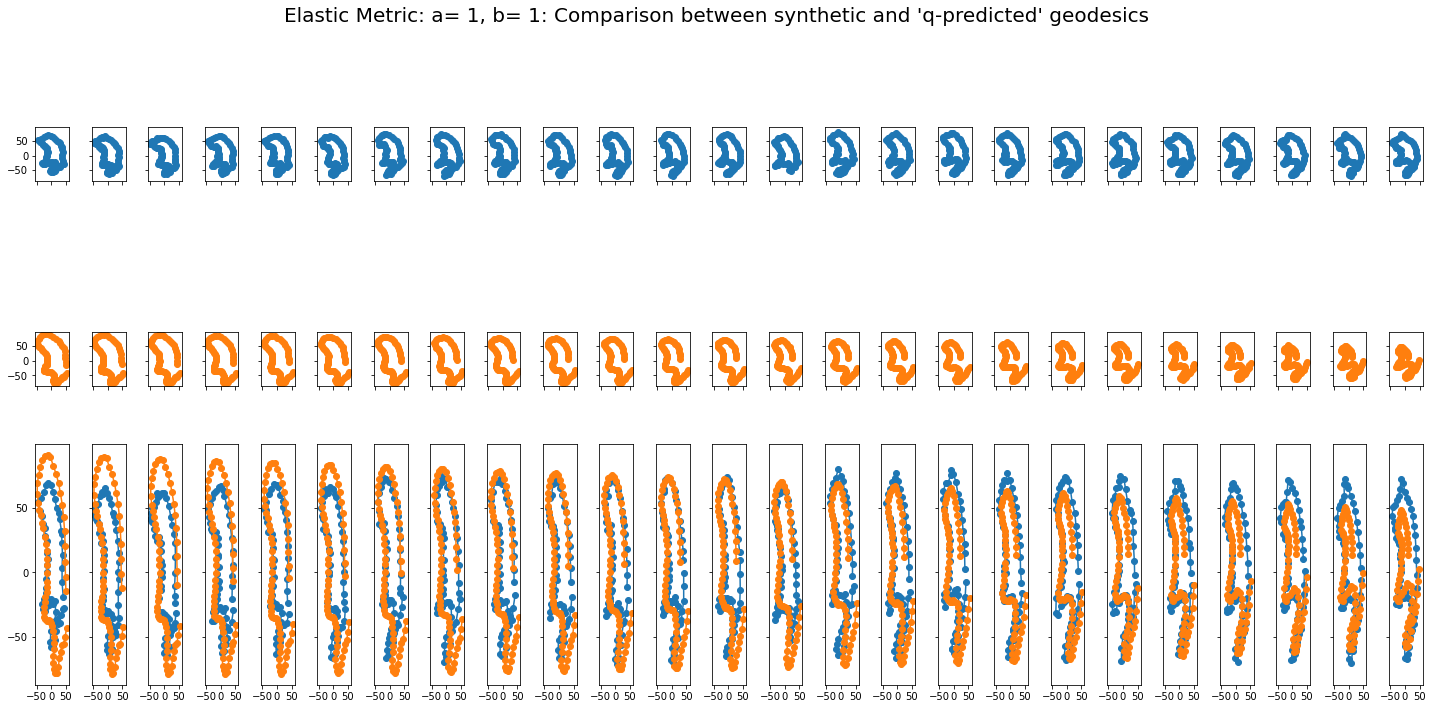

In [89]:
import importlib
importlib.reload(qfit)

qfit.ftrans_plot_predictions(shapes_traj[0],a=1,b=1,split=False)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


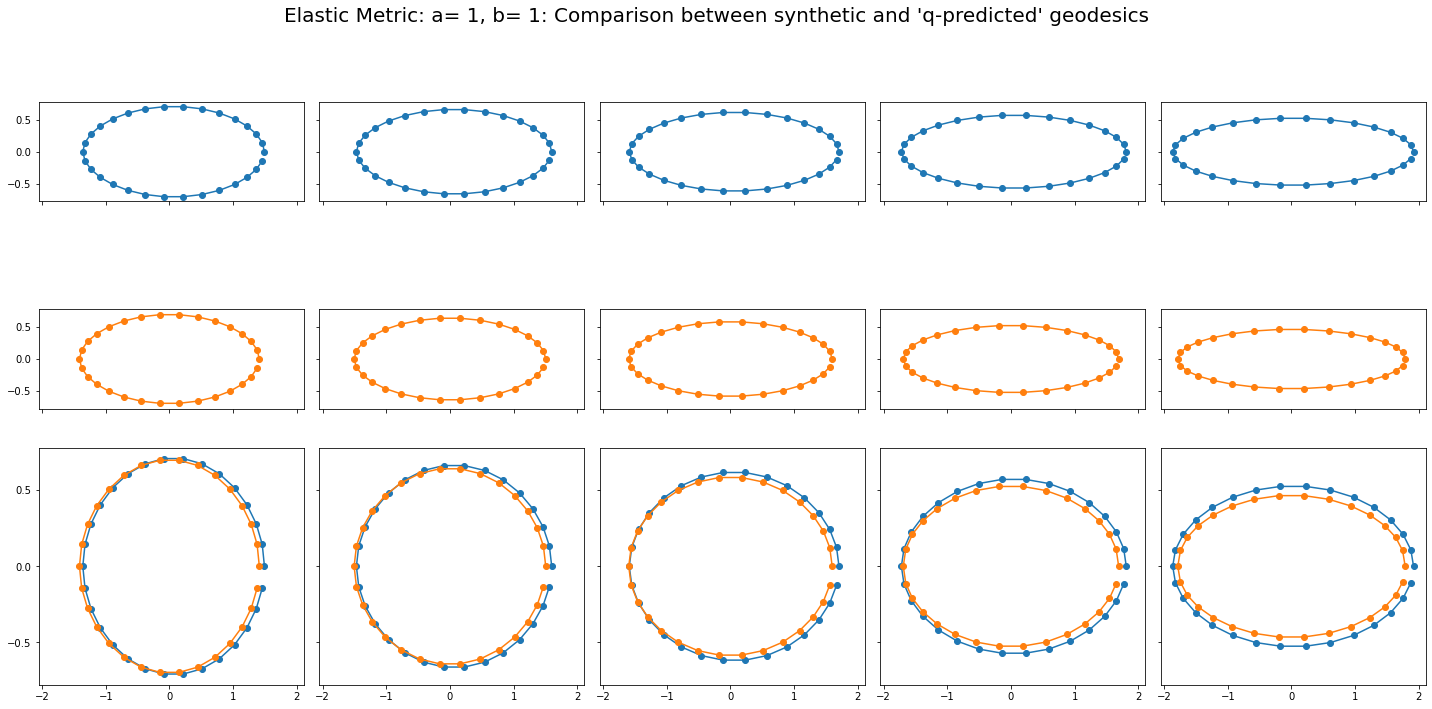

In [74]:
import dyn.dyn.datasets.synthetic as synthetic

n_geodesics = 1
n_times = 10
n_points = 30

#creating our synthetic dataset
geods_circle_ell = synthetic.geodesics_circle_to_ellipse(
    n_geodesics=n_geodesics, n_times=n_times, n_points=n_points
)

qfit.ftrans_plot_predictions(geods_circle_ell[0],1,1,split=True)

# 3. Testing different values of a and b

$\textbf{The plan:}$ I will test $\textbf{each trajectory}$ with different values of a and b. I will test each trajectory separately because there is no way to know whether every cell's trajectory will be best fit by the same set of a and b.

In the future (maybe): For each trajectory, i will determine which set of a and b minimizes the r^2 value of the linear regression, and then i will 

idea: calculate the r^2 value for a large set of a and b and see which set of a and b minimizes the r^2 value and see if that matches what we see.

## 3.1 Testing geodesic 0

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


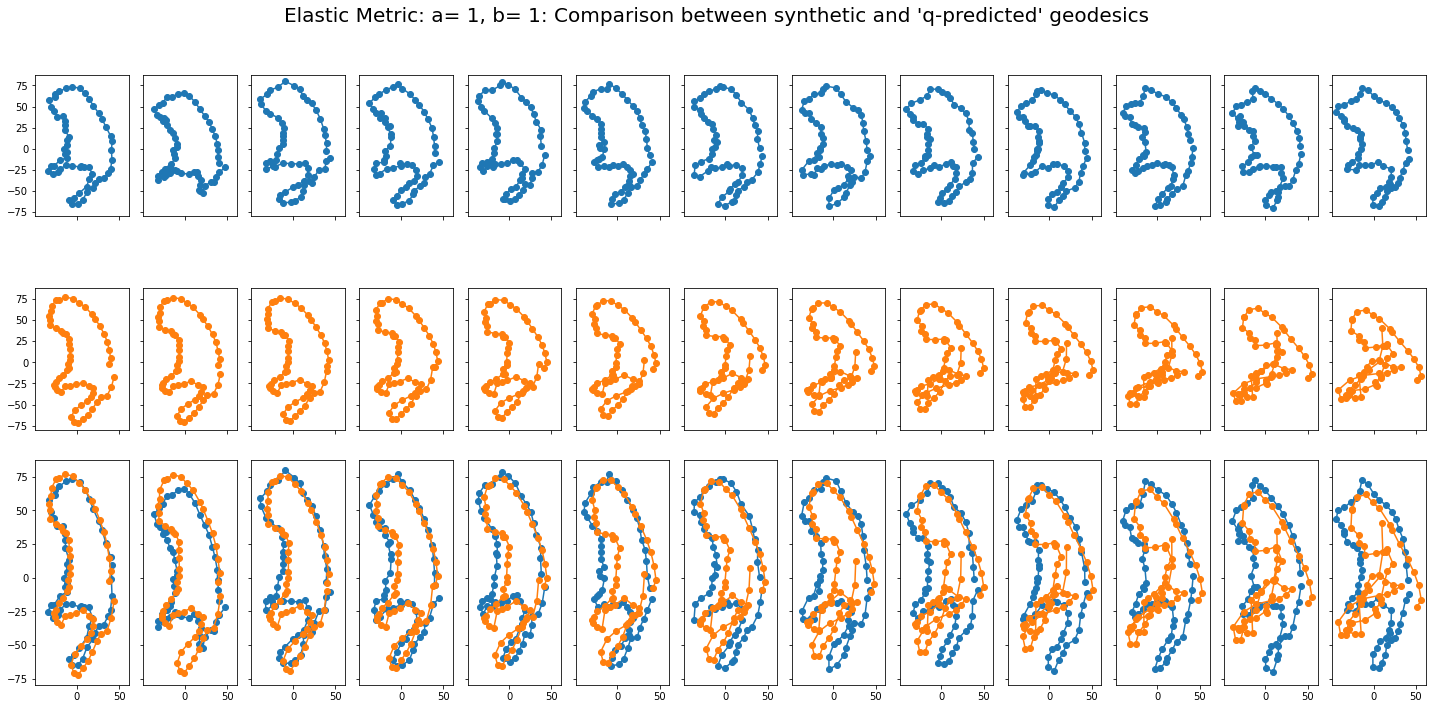

In [80]:
qfit.ftrans_plot_predictions(shapes_traj[0],a=1,b=1,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


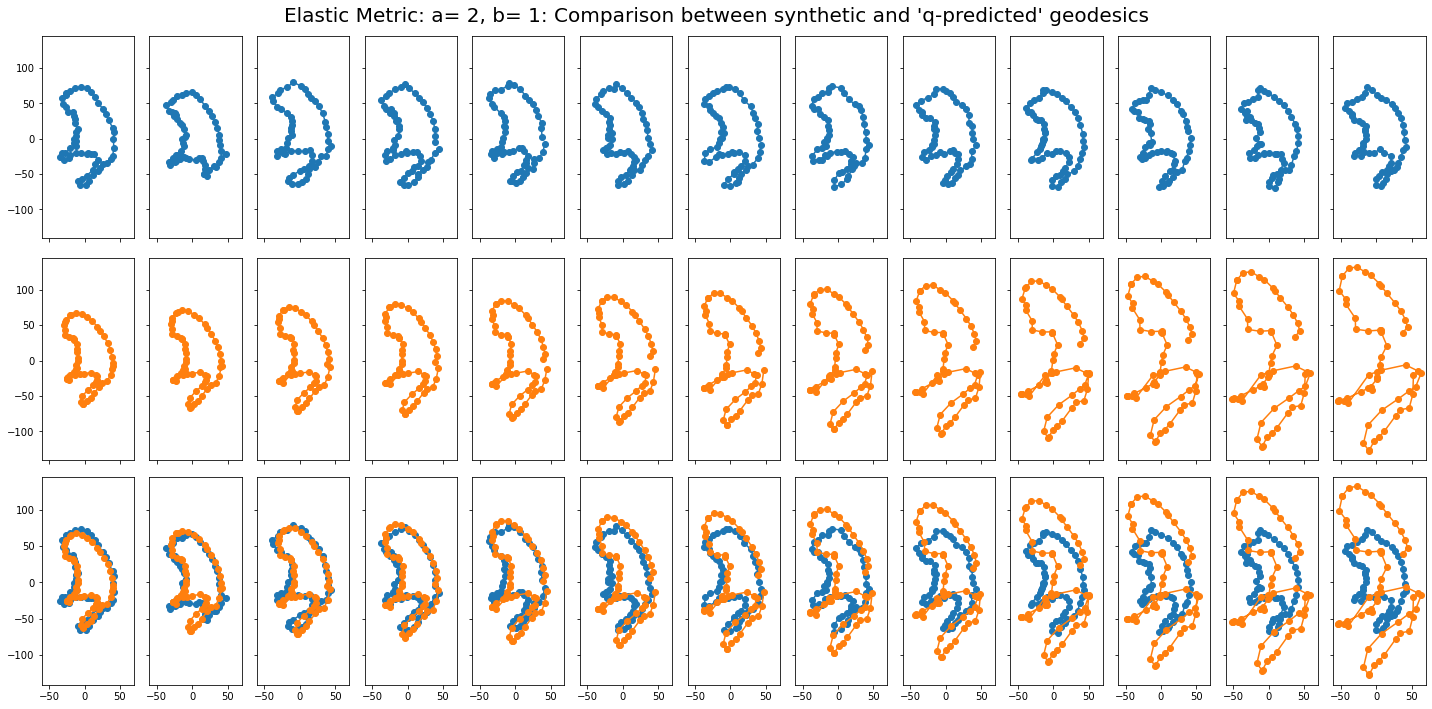

In [81]:
qfit.ftrans_plot_predictions(shapes_traj[0],a=2,b=1,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


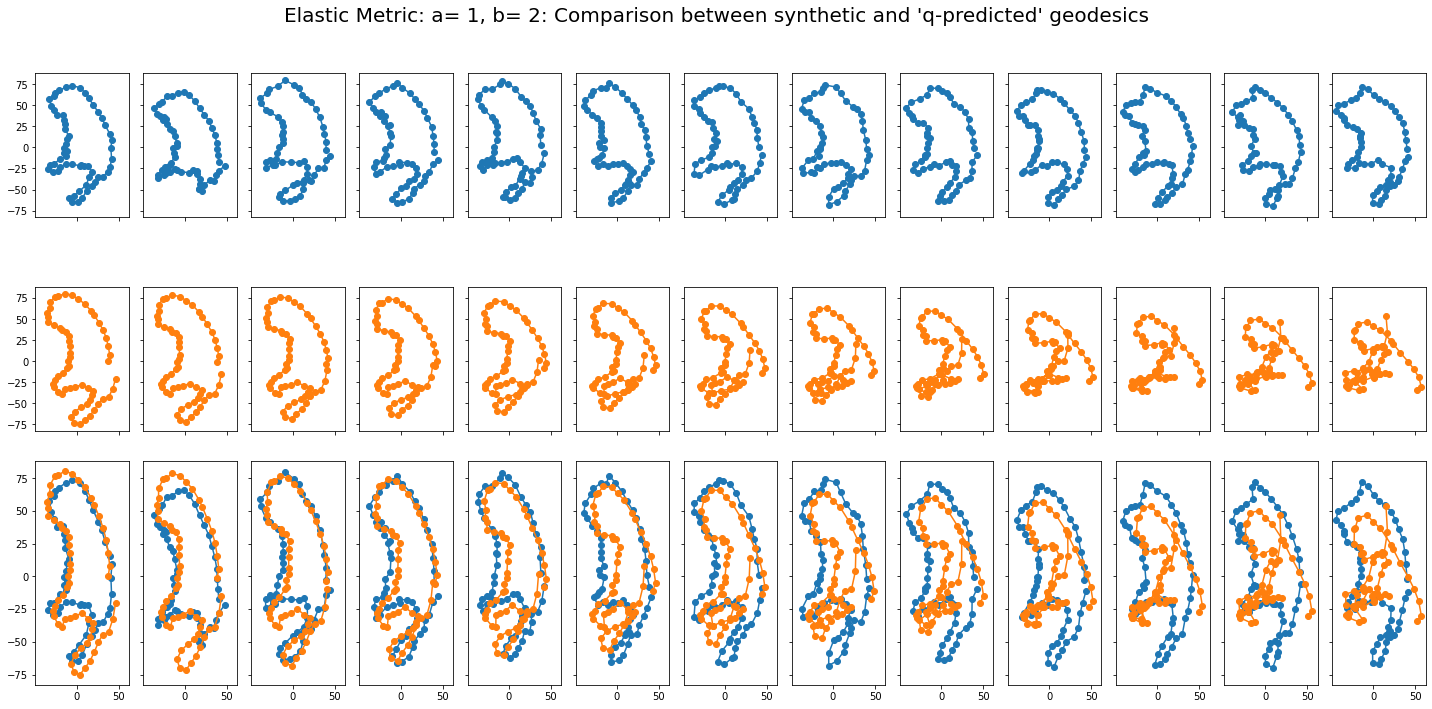

In [83]:
qfit.ftrans_plot_predictions(shapes_traj[0],a=1,b=2,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


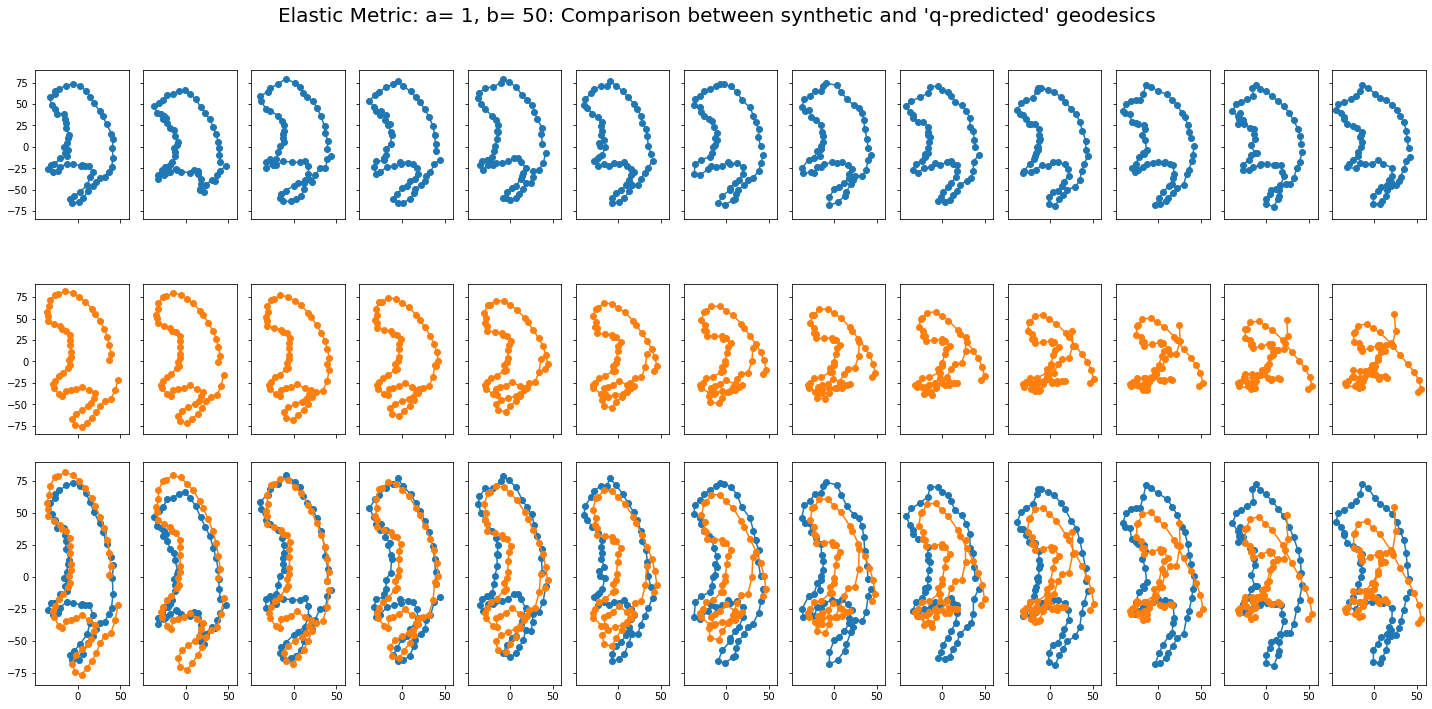

In [86]:
qfit.ftrans_plot_predictions(shapes_traj[0],a=1,b=50,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


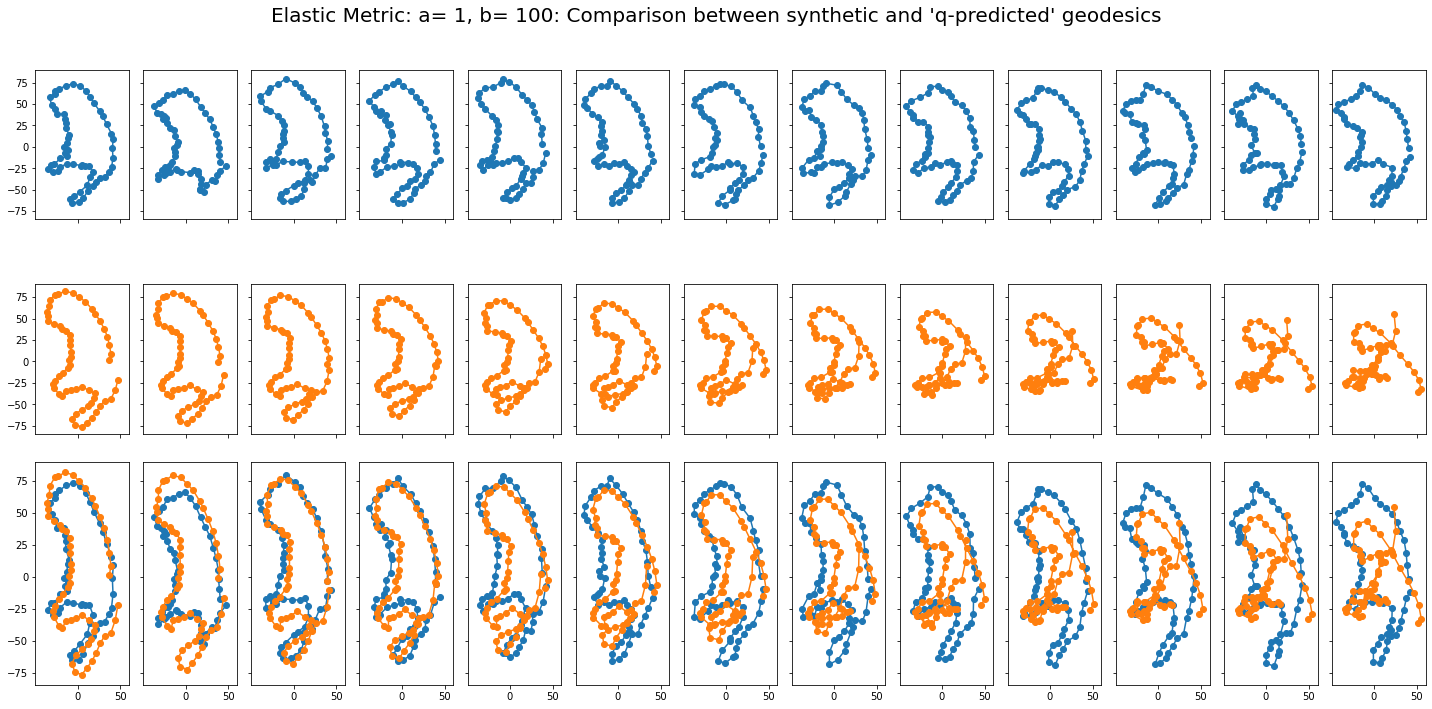

In [87]:
qfit.ftrans_plot_predictions(shapes_traj[0],a=1,b=100,split=True)

## 3.1 Testing geodesic 1

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


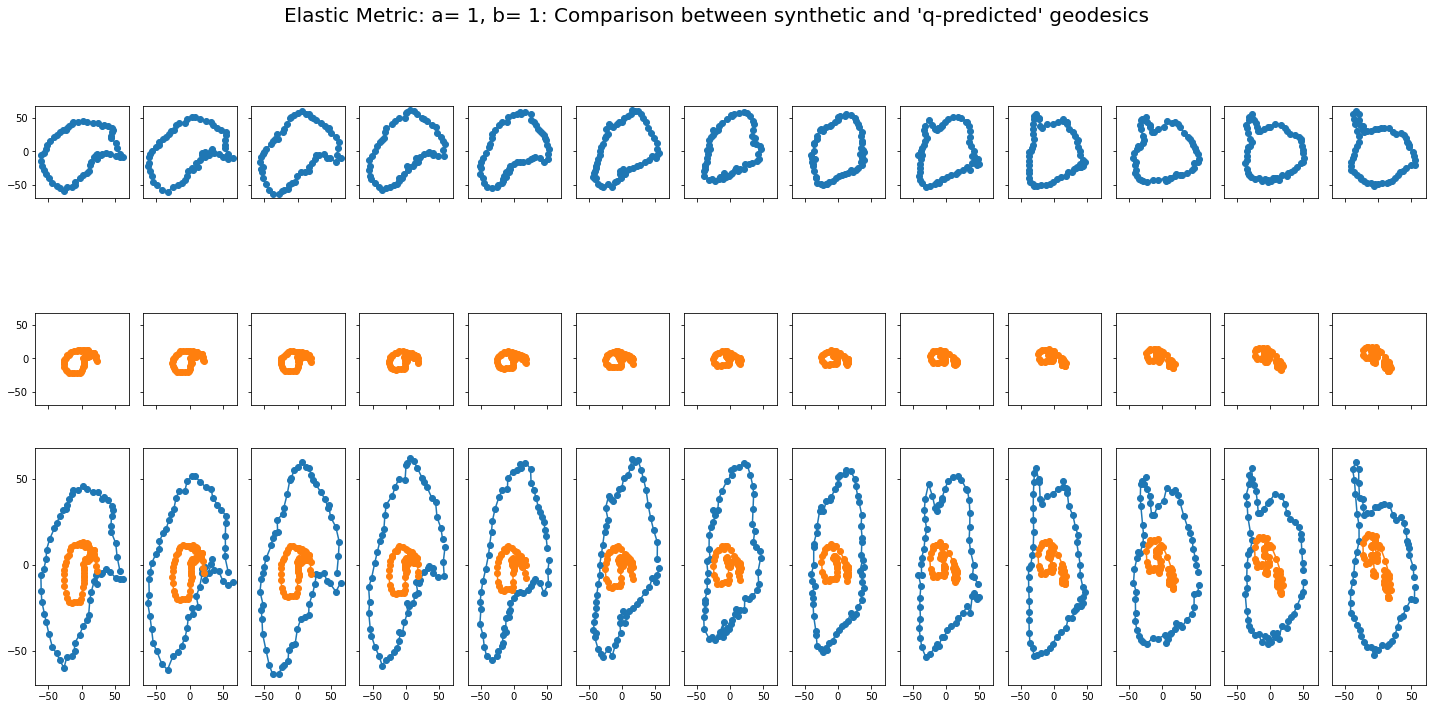

In [88]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=1,b=1,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


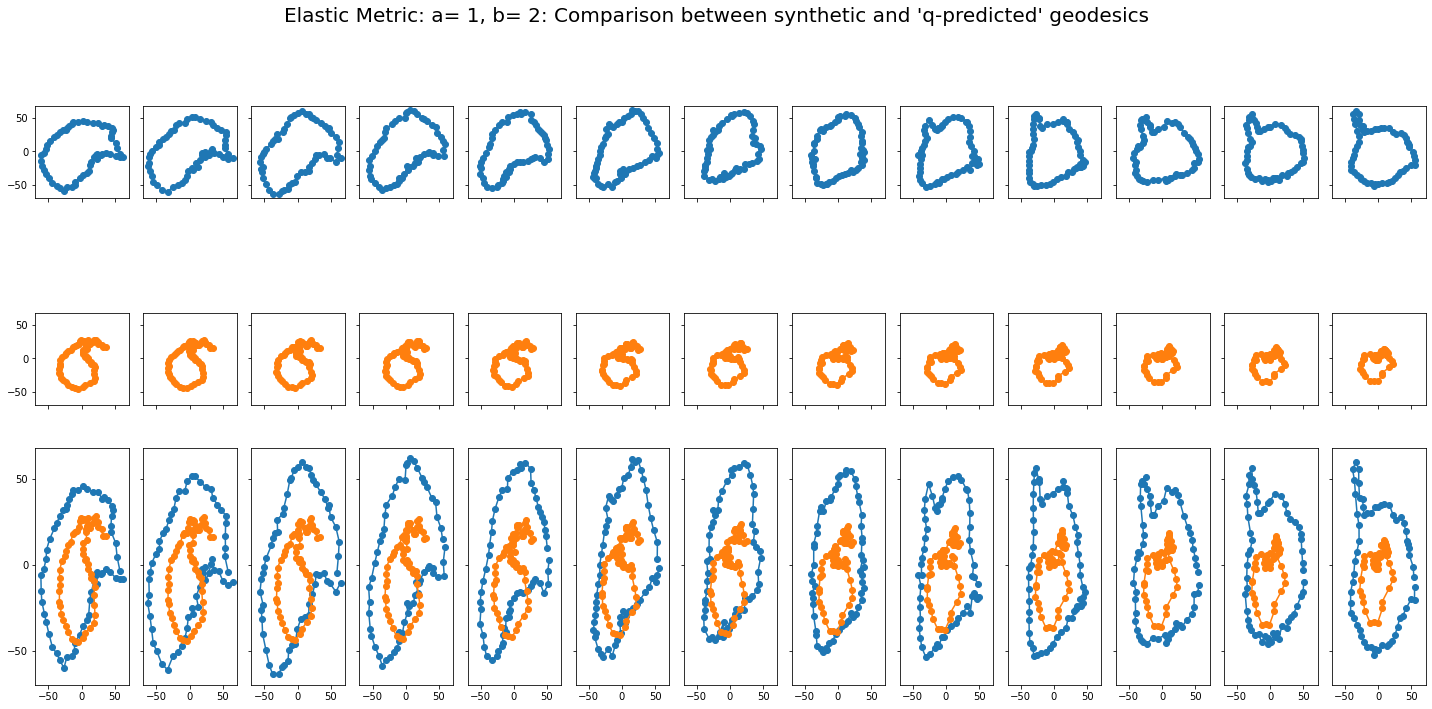

In [90]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=1,b=2,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


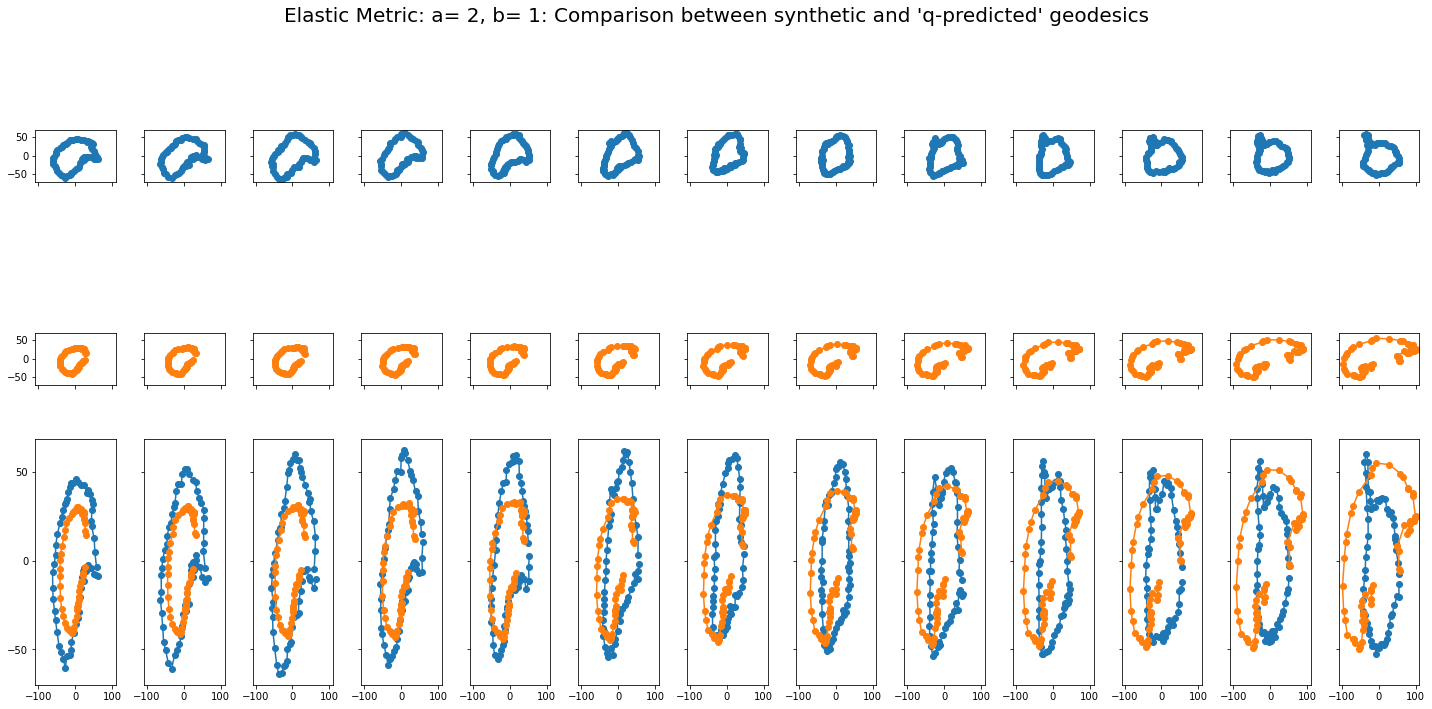

In [91]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=2,b=1,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


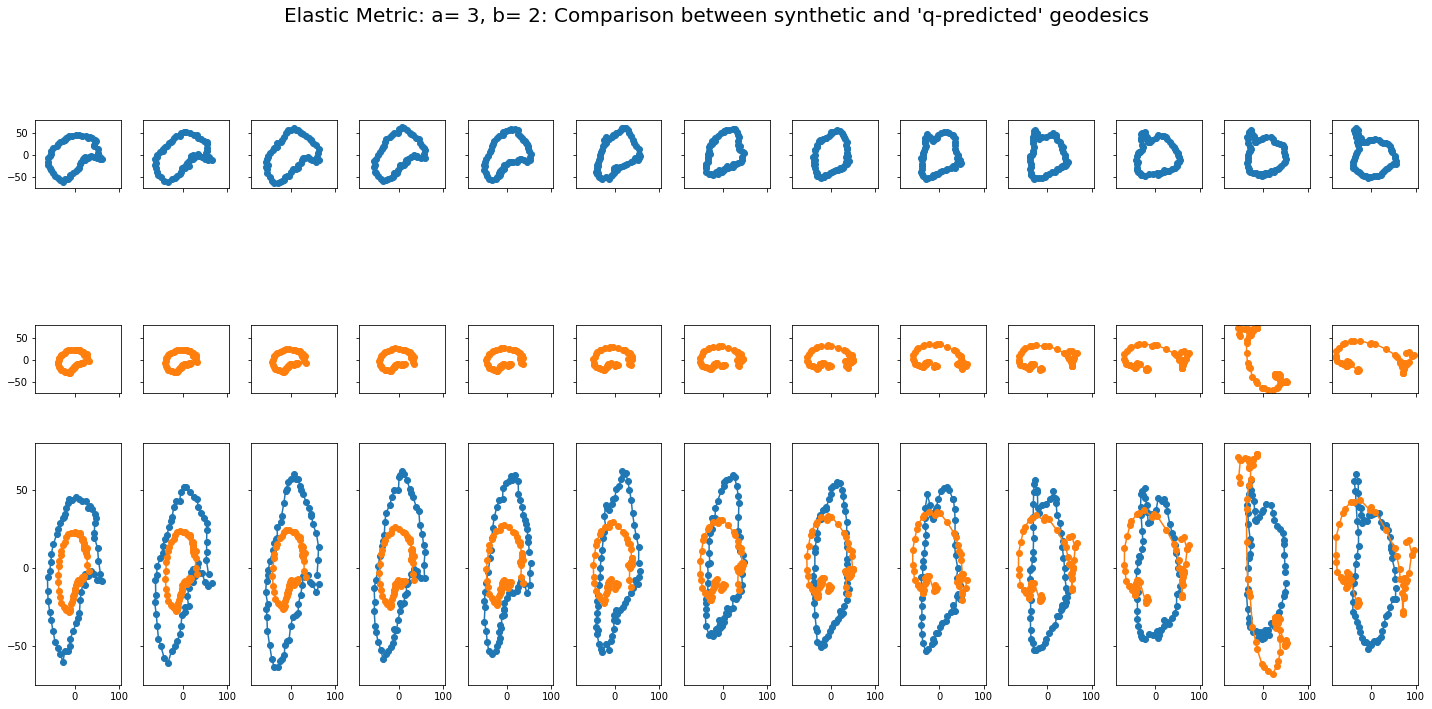

In [93]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=3,b=2,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


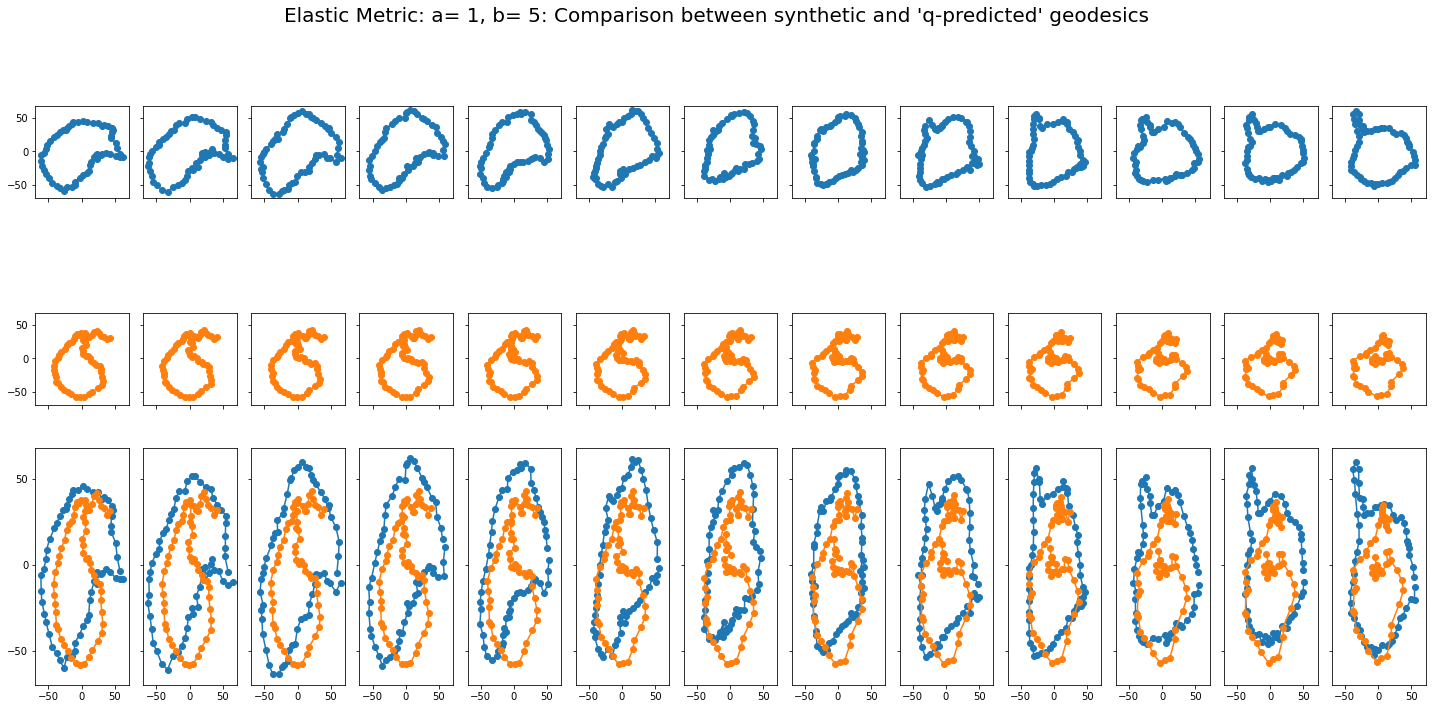

In [94]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=1,b=5,split=True)

/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])
/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  geodesic_array= np.array([geodesic[half_n_times:],recentered_curves])


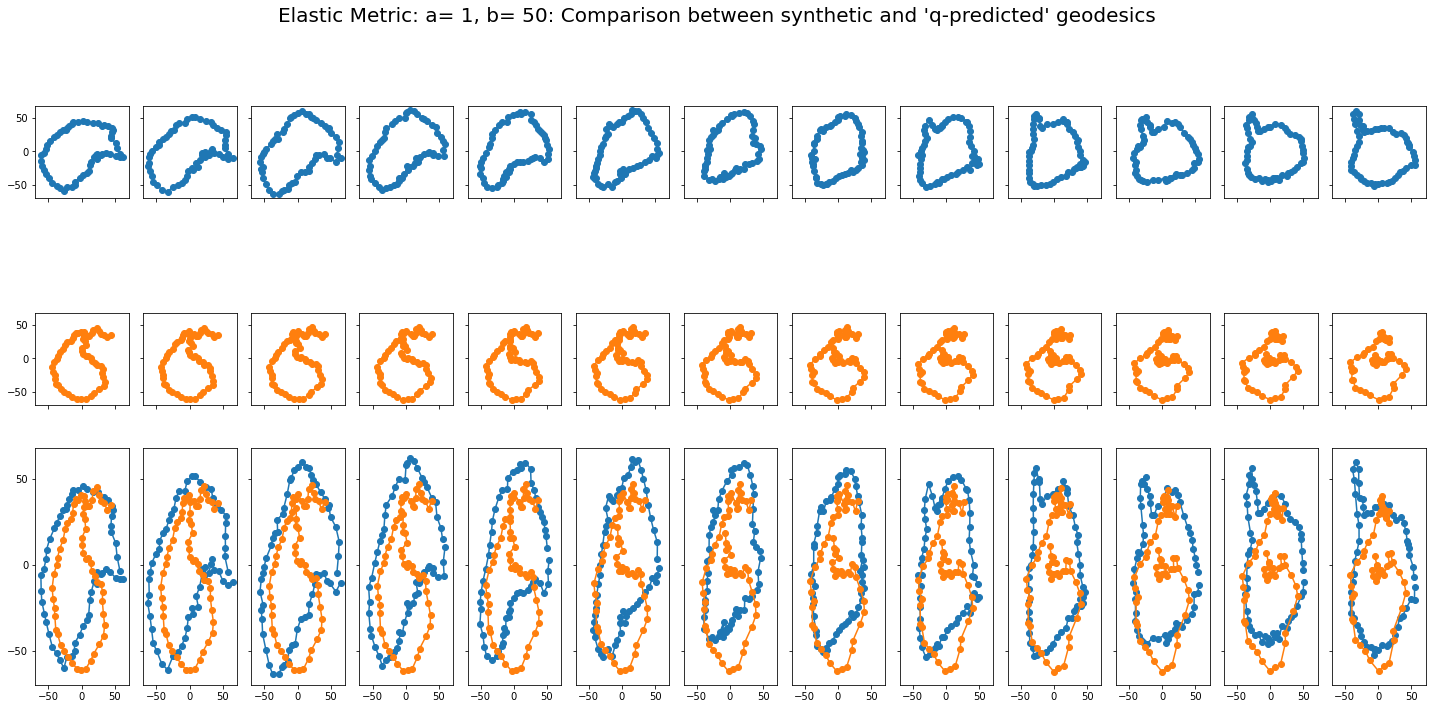

In [96]:
qfit.ftrans_plot_predictions(shapes_traj[1],a=1,b=50,split=True)

# What would it look like to write a function that minimized the R^2 value

In [118]:
import importlib
importlib.reload(qfit)

qfit.optimize_ab(shapes_traj[0])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/adelemyers/anaconda3/envs/dyn/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yw/6dl955ps7fj9ysnf7qh0j4tc0000gn/T/ipykernel_51861/3004829709.py", line 4, in <cell line: 4>
    qfit.optimize_ab(shapes_traj[15])
  File "/Users/adelemyers/code/dyn/dyn/features/f_fit_functions.py", line 419, in optimize_ab
    regr.fit(q_times,q_vector)
  File "/Users/adelemyers/anaconda3/envs/dyn/lib/python3.8/site-packages/sklearn/linear_model/_base.py", line 684, in fit
    X, y = self._validate_data(
  File "/Users/adelemyers/anaconda3/envs/dyn/lib/python3.8/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/adelemyers/anaconda3/envs/dyn/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1090, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_

In [119]:
qfit.optimize_ab(geods_circle_ell[0])

(1, 0.5, 0.9787362016243422)